In [22]:
from ast import Del
from calendar import month, week
from datetime import timedelta
from tkinter import NS
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import maturity_payoff,quarterly_payoff
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from dateutil.relativedelta import relativedelta

## No Variance Reduction Simulation

/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/La

Variance of expected payoff: 3454.167331205623 for 5000 Simulations.


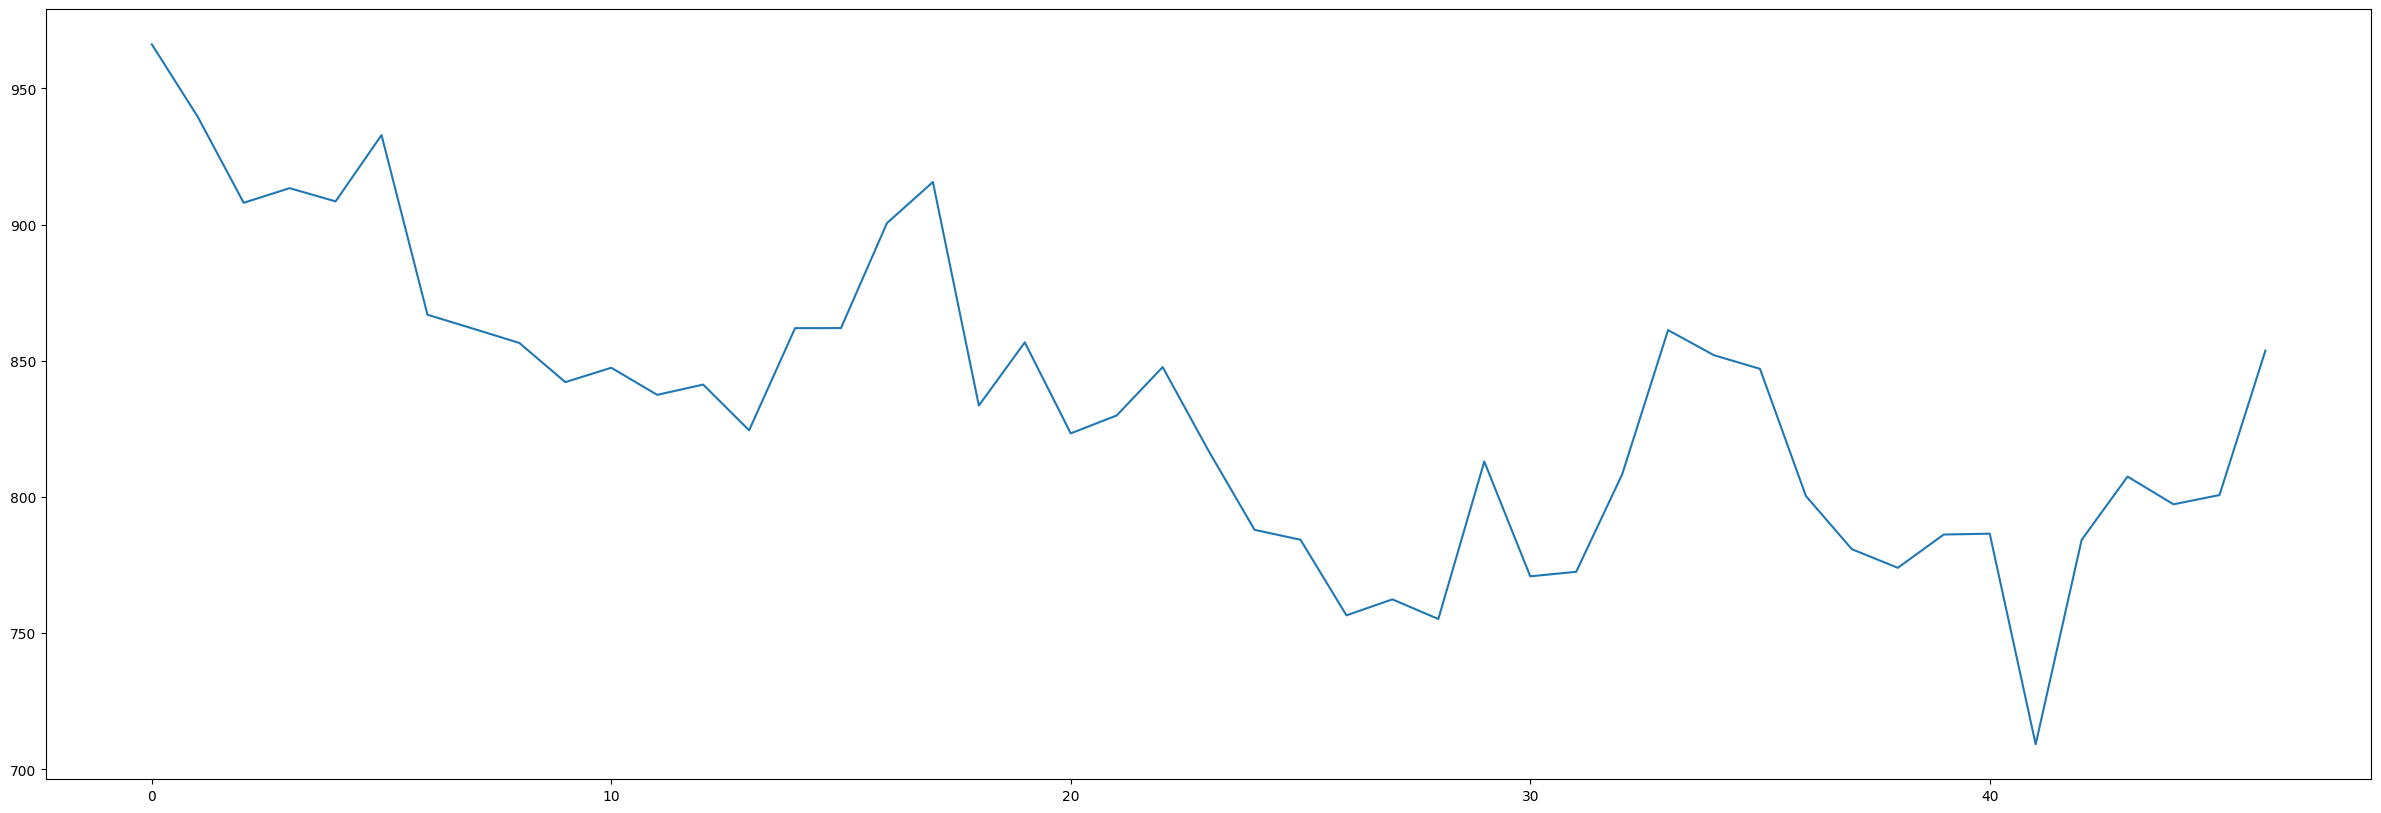

In [23]:
date_to_predict,hist_end,end_date,q2_to_maturity,q3_to_maturity,q2,q3,total_trading_days,holidays = days(latest_price_date='2022-10-24')

trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []

while date_to_predict<=end_date:

    if date_to_predict in holidays or date_to_predict.weekday()==5 or date_to_predict.weekday()==6:
        date_to_predict+=relativedelta(days=+1)
        trading_days_to_simulate-=1
        hist_end+=relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv',hist_start,hist_end).rename(columns={'Close/Last':'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv',hist_start,hist_end).rename(columns={'Close/Last':'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv',hist_start,hist_end).rename(columns={'Close/Last':'GOOGL'})
    temp_df = aapl.merge(amzn,on=['Date'])
    AAG = temp_df.merge(googl,on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0-1,:] - AAGlogprices[1:,:]

    v = np.mean(AAGlogreturns,axis=0)
    sigma = np.cov(AAGlogreturns,rowvar=False)
    Nsim=5000
    T=trading_days_to_simulate
    dt=1
    m=int(T/dt)
    r=0.04716

    S0=AAGprices[0,:]
    S1=np.zeros((Nsim,m+1))
    S2=np.zeros((Nsim,m+1))
    S3=np.zeros((Nsim,m+1))
    random.seed(4518)

    for i in range(1,Nsim+1):
        S=SimMultiGBM(S0,v,sigma,dt,T)
        S1[i-1:i,:] = S[0:1,:]
        S2[i-1:i,:] = S[1:2,:]
        S3[i-1:i,:] = S[2:3,:]

    # S1 = EMS(S1,dt,r)
    # # S2 = EMS(S2,dt,r)
    # S3 = EMS(S3,dt,r)

    payoff_maturity = []
    payoff_q2 = []
    payoff_q3 = []

        

    for i in range(0,Nsim):
        payoff_maturity.append(maturity_payoff(aapl=S1[i,:],amzn=S2[i,:],googl=S3[i,:]))

        # if cur_date<q2:
        #     payoff_q2.append(quarterly_payoff(S1[i,:len(S1[i,:])-q2_to_maturity],S2[i,:len(S2[i,:])-q2_to_maturity],S3[i,:len(S3[i,:])-q2_to_maturity],2))

        # if cur_date<q3:
        #     payoff_q3.append(quarterly_payoff(S1[i,:len(S1[i,:])-q3_to_maturity],S2[i,:len(S2[i,:])-q3_to_maturity],S3[i,:len(S3[i,:])-q3_to_maturity],3))
    
    
    cur_expected_payoff = np.mean(payoff_maturity)
    expected_payoff_maturity.append(cur_expected_payoff)

    #TODO Apply regression to find the coefficient for each payoff
    # option_price = np.exp(-r*(trading_days_to_predict/total_trading_days))*cur_expected_payoff*w_1 + np.exp(-r/2)*np.mean(payoff_q2)*w_2 + np.exp(-r*3/4)*np.mean(payoff_q3)*w_3
    option_price = np.exp(-r*(trading_days_to_simulate/total_trading_days))*cur_expected_payoff
    predicted_option_price.append(option_price)

    date_to_predict+=relativedelta(days=+1)
    trading_days_to_simulate-=1
    hist_end+=relativedelta(days=+1)

print(f'Variance of expected payoff: {np.var(expected_payoff_maturity)} for {Nsim} Simulations.')

plt_1 = plt.figure(figsize=(30,10))
plt.plot(predicted_option_price)

## Antithetic Variance Reduction Simulation

/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/La

Variance of expected payoff: 3461.5814937483087


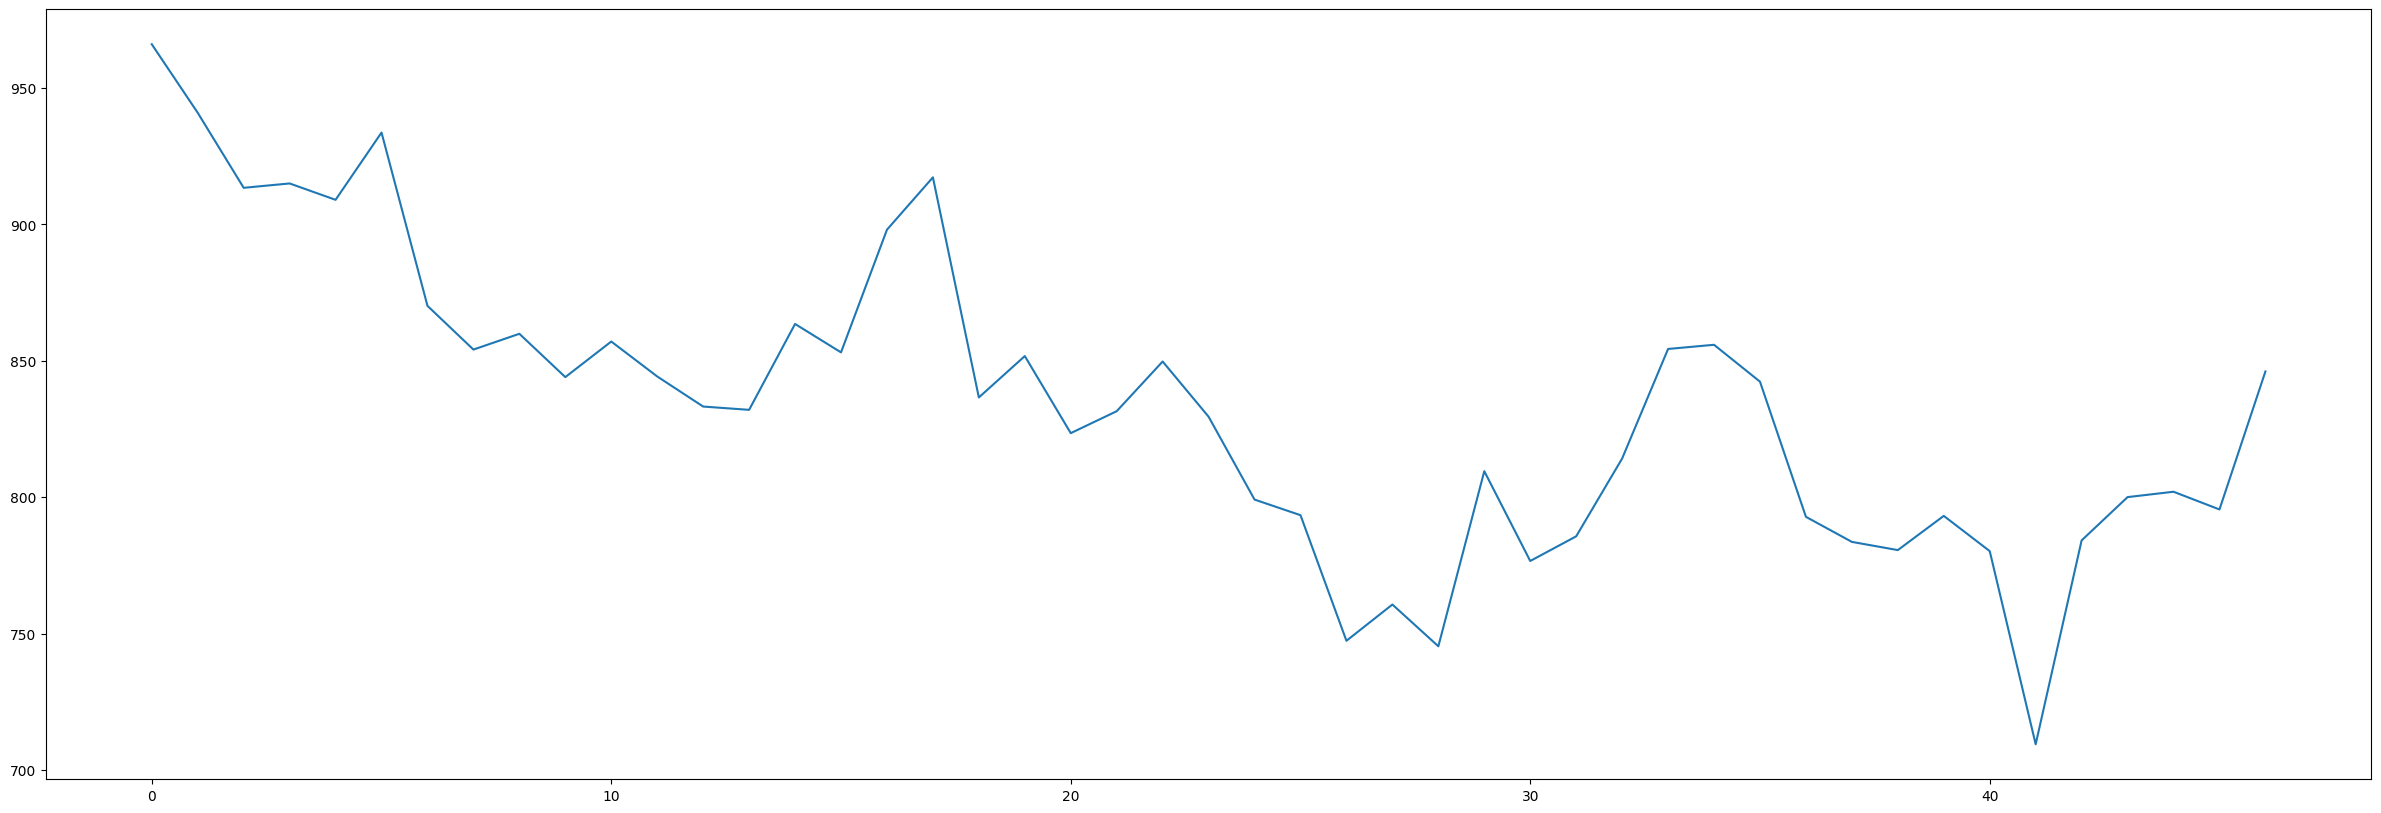

In [19]:
date_to_predict,hist_end,end_date,q2_to_maturity,q3_to_maturity,q2,q3,total_trading_days,holidays = days(latest_price_date='2022-10-24')

trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []

while date_to_predict<=end_date:
    
    if date_to_predict in holidays or date_to_predict.weekday()==5 or date_to_predict.weekday()==6:
        date_to_predict+=relativedelta(days=+1)
        trading_days_to_simulate-=1
        hist_end+=relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv',hist_start,hist_end).rename(columns={'Close/Last':'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv',hist_start,hist_end).rename(columns={'Close/Last':'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv',hist_start,hist_end).rename(columns={'Close/Last':'GOOGL'})
    temp_df = aapl.merge(amzn,on=['Date'])
    AAG = temp_df.merge(googl,on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0-1,:] - AAGlogprices[1:,:]

    v = np.reshape(np.mean(AAGlogreturns,axis=0),(3,1))
    sigma = np.cov(AAGlogreturns,rowvar=False)
    Nsim=2500
    T=trading_days_to_simulate
    dt=1
    m=int(T/dt)
    r=0.04716


    S0=AAGprices[0,:]
    S1=np.zeros((Nsim,m+1))
    S2=np.zeros((Nsim,m+1))
    S3=np.zeros((Nsim,m+1))
    random.seed(4518)

    for i in range(1,Nsim+1):
        S,Stilde=SimMultiGBMAV(S0,v,sigma,dt,T)
        S1[i-1:i,:] = S[0:1,:]
        S1[Nsim+i:Nsim+i+1,:] = Stilde[0:1,:]
        S2[i-1:i,:] = S[1:2,:]
        S2[Nsim+i:Nsim+i+1,:] = Stilde[1:2,:]
        S3[i-1:i,:] = S[2:3,:]
        S3[Nsim+i:Nsim+i+1,:] = Stilde[2:3,:]

    # S1 = EMS(S1,dt,r)
    # S2 = EMS(S2,dt,r)
    # S3 = EMS(S3,dt,r)

    payoff_maturity = []
    payoff_q2 = []
    payoff_q3 = []

        

    for i in range(0,Nsim):
        payoff_maturity.append(maturity_payoff(aapl=S1[i,:],amzn=S2[i,:],googl=S3[i,:]))

        # if cur_date<q2:
        #     payoff_q2.append(quarterly_payoff(S1[i,:len(S1[i,:])-q2_to_maturity],S2[i,:len(S2[i,:])-q2_to_maturity],S3[i,:len(S3[i,:])-q2_to_maturity],2))

        # if cur_date<q3:
        #     payoff_q3.append(quarterly_payoff(S1[i,:len(S1[i,:])-q3_to_maturity],S2[i,:len(S2[i,:])-q3_to_maturity],S3[i,:len(S3[i,:])-q3_to_maturity],3))
    
    
    cur_expected_payoff = np.mean(payoff_maturity)
    expected_payoff_maturity.append(cur_expected_payoff)

    #TODO Apply regression to find the coefficient for each payoff
    # option_price = np.exp(-r*(trading_days_to_predict/total_trading_days))*cur_expected_payoff*w_1 + np.exp(-r/2)*np.mean(payoff_q2)*w_2 + np.exp(-r*3/4)*np.mean(payoff_q3)*w_3
    option_price = np.exp(-r*(trading_days_to_simulate/total_trading_days))*cur_expected_payoff
    predicted_option_price.append(option_price)

    date_to_predict+=relativedelta(days=+1)
    hist_end+=relativedelta(days=+1)
    trading_days_to_simulate-=1

print(f'Variance of expected payoff: {np.var(expected_payoff_maturity)} for {Nsim} Simulations.')
plt_1 = plt.figure(figsize=(30,10))
plt.plot(predicted_option_price)